# Prediction of scooter usage


## 1. Explorative Data Analysis
### Import & Preprocessing of data


In [ ]:
#import data
import pandas as pd
from google.colab import files

uploaded = files.upload()

In [ ]:
import io
import numpy as np
import pandas as pd

df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']))
df

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

#for more custom plot colours
color_pal = sns.color_palette()


In [ ]:
#Check datatypes
result = df.dtypes

print(result)

In [ ]:
#Convert co into float to be able to use it later on (date will be converted later)
df['co'] = df['co'].str.replace(',','.')
df['co'] = df['co'].astype(float)
df

In [ ]:
#Check datatypes again
result = df.dtypes

print(result)

## Combine date and hour

In [ ]:
df['hourly'] = pd.to_datetime(df['hour'], format='%H')
df


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import datetime as dt

arr = np.array([])
for row in range(len(df)):
    date = dt.datetime.strptime(df['date'][row], '%Y-%m-%d')
    arr = np.append(arr, dt.datetime.combine(date, df['hourly'][row].time()))
df['datetime'] = arr.tolist()
df

In [ ]:
df.drop(columns=['hourly', 'date'], inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)
df

In [ ]:
#check if datetime are only unique values before making it the index
df['datetime'].duplicated().any() # True

False

In [ ]:
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)
df

## Visualise Data

In [ ]:
df['type_ab'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Combined Usage over time')
plt.show()

In [ ]:
df['weather'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Weather over time')
plt.show()

In [ ]:
df['temp'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Temperature over time')
plt.show()

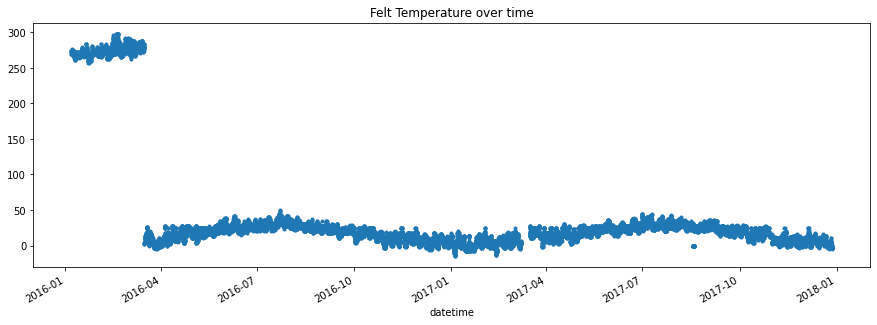

In [ ]:
df['temp_felt'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Felt Temperature over time')
plt.show()

In [ ]:
df['humidity'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Humidity over time')
plt.show()

In [ ]:
df['windspeed'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Windspeed over time')
plt.show()

In [ ]:
df['co'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='CO over time')
plt.show()

**Comment:** For the different data points, it is clear that there are some errors in the usage (containing negative numbers), temperature & felt temperature (both at one point being higher than 200) and CO (negative numbers).  

In [ ]:
#get number of negative values per category
df.lt(0).sum()

Since co has 3700 of 17144 with negative values, and they are spread through out, CO will be excluded from further analysis



### Further Investigation of the errors in usage, temperature and felt temperature

In [ ]:
df['type_ab'].iloc[1:1000].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Combined Usage over time')
plt.show()

In [ ]:
df['type_ab'].iloc[180:570].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Combined Usage over time')
plt.show()

In [ ]:
zero_us = df.index[df['type_ab'] == 0].tolist()
zero_us

[]

In [ ]:
df['temp'].iloc[0:2000].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Temperatue over time')
plt.show()

In [ ]:
high_temp = df.index[df['temp'] >= 200].tolist()
high_temp

In [ ]:
high_temp_fe = df.index[df['temp_felt'] >= 200].tolist()
high_temp_fe

**Comment:** As the values are almost at the beginning, the decision was made to exclude the dates from further time series analysis.

In [ ]:
#Start 2016-02-21
cutoff_date = '2016-02-20 23:00:00'
df = df[(df.index > cutoff_date)]
df

In [ ]:
high_temp = df.index[df['temp'] >= 200].tolist()
high_temp

In [ ]:
high_temp_fe = df.index[df['temp_felt'] >= 200].tolist()
high_temp_fe

**Comment:** The official start date of the time series will be the 17th March 2016 at 00:00:00, to exclude any possible errors from usage, temperature and felt temperature.

In [ ]:
#Start 2016-02-21
cutoff_date = '2016-03-16 23:00:00'
df = df[(df.index > cutoff_date)]
df

In [ ]:
#Other missing values will be filled with 0
df = df.fillna(0)


In [ ]:
maxValues = df.max(skipna=False)

print(maxValues)

In [ ]:
minValues = df.min(skipna=False)
print(minValues)

In [ ]:
#negative in usage values with 0
df[df['type_ab'] < 0] = 0

In [ ]:
minValues = df.min(skipna=False)
print(minValues)

In [ ]:
df.drop(columns=['hour', 'type_a', 'type_b', 'co'], inplace=True)
df

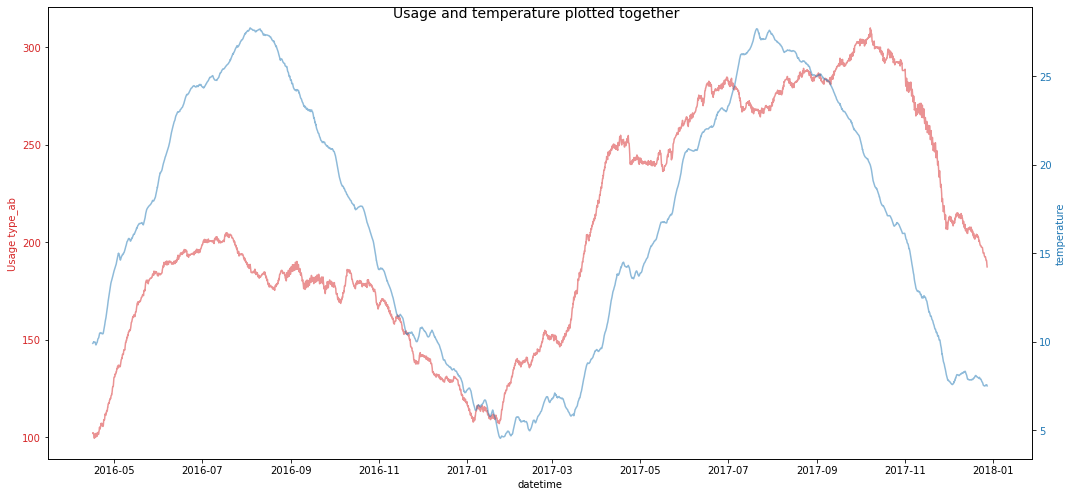

In [ ]:
#@title Feature Relationship Exploration
# Plotting the usage and temperature data on the same graph as line plots
fig, ax1 = plt.subplots(figsize=(15,7))
rolling_num = 24*30
color = 'tab:red'
ax1.set_xlabel('datetime')
ax1.set_ylabel('Usage type_ab', color = color)
ax1.plot(df['type_ab'].rolling(rolling_num).mean(), color = color, alpha = 0.5)
ax1.tick_params(axis='y', labelcolor = color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('temperature', color = color)
ax2.plot(df['temp'].rolling(rolling_num).mean(), color = color, alpha = 0.5)
ax2.tick_params(axis='y', labelcolor = color)

fig.suptitle('Usage and temperature plotted together', fontsize = 14)
fig.tight_layout()
plt.show()

In [ ]:
#Test Correlation
corr_matrix = df.corr()
print(corr_matrix)

**Comment:** High correlation was found between temp and temp_felt which was expected.
Furthermore there is a slight correlation between weather and humidity, which also makes sense.

# Train/Test/Validation Split

In [ ]:

from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()

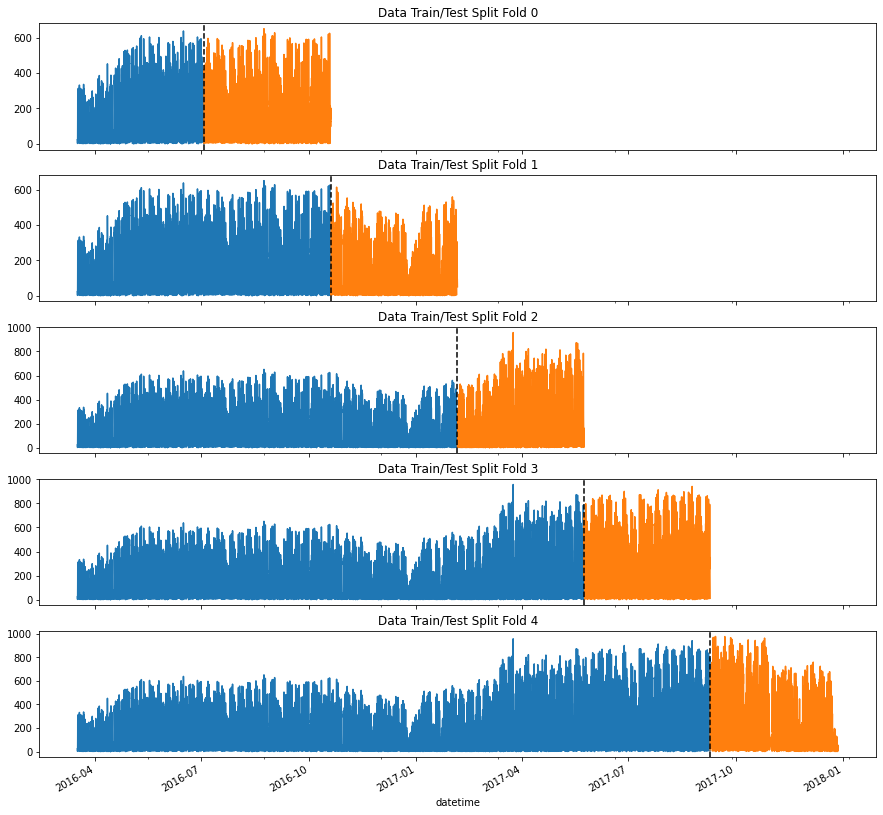

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['type_ab'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['type_ab'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()


# Feature Creation

In [ ]:
import datetime
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [ ]:
df

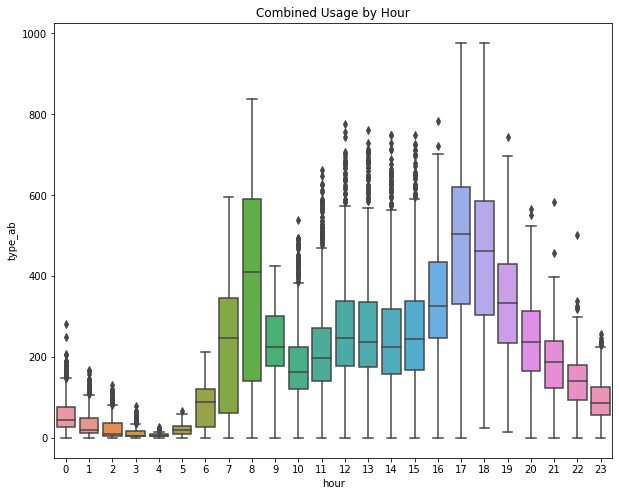

In [ ]:
#Visualise Feature Relationship
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='type_ab')
ax.set_title('Combined Usage by Hour')
plt.show()

**Comment:** The usage in the nightly hours is lower than during the day.

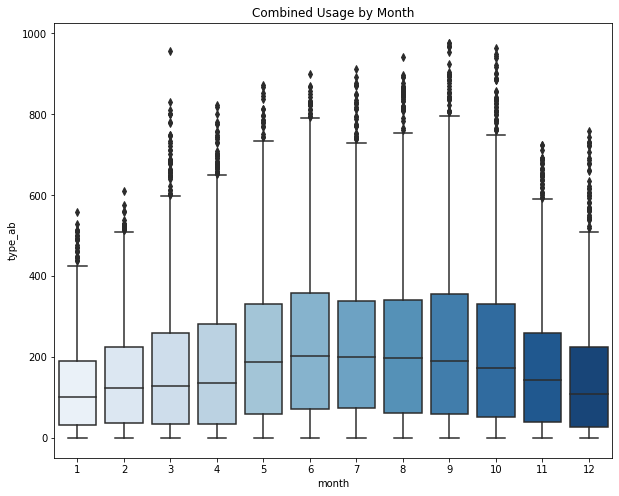

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='type_ab', palette='Blues')
ax.set_title('Combined Usage by Month')
plt.show()

# Training models with different features

In [ ]:
#@title Train using Cross Validation 1
tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year']
    TARGET = 'type_ab'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg1 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                            n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg1.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg1.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[21:29:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:211.931	validation_1-rmse:232.941
[100]	validation_0-rmse:112.495	validation_1-rmse:124.122
[200]	validation_0-rmse:79.2357	validation_1-rmse:91.0826
[300]	validation_0-rmse:67.9418	validation_1-rmse:82.2832
[400]	validation_0-rmse:63.2875	validation_1-rmse:80.4542
[500]	validation_0-rmse:60.915	validation_1-rmse:80.8676
[600]	validation_0-rmse:58.4196	validation_1-rmse:80.3279
[700]	validation_0-rmse:56.1704	validation_1-rmse:79.8985
[800]	validation_0-rmse:52.7292	validation_1-rmse:78.5037
[900]	validation_0-rmse:49.2827	validation_1-rmse:76.3381
[999]	validation_0-rmse:47.6647	validation_1-rmse:75.3848
[21:29:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:222.691	validation_1-rmse:177.667
[100]	validation_0-rmse:118.601	validation_1-rmse:95.30

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 103.5576
Fold scores:[75.38480170956689, 68.156231189567, 143.21914670732116, 109.31914659481369, 121.70867252748397]


In [ ]:
#@title Train using Cross Validation 2
tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'holiday']
    TARGET = 'type_ab'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg2 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                            n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg2.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg2.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[21:30:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:211.931	validation_1-rmse:232.941
[100]	validation_0-rmse:112.495	validation_1-rmse:124.122
[200]	validation_0-rmse:79.2357	validation_1-rmse:91.0826
[300]	validation_0-rmse:67.9418	validation_1-rmse:82.2832
[400]	validation_0-rmse:63.2875	validation_1-rmse:80.4542
[500]	validation_0-rmse:60.915	validation_1-rmse:80.8676
[600]	validation_0-rmse:58.4196	validation_1-rmse:80.3279
[700]	validation_0-rmse:56.1704	validation_1-rmse:79.8985
[800]	validation_0-rmse:52.6987	validation_1-rmse:78.4548
[900]	validation_0-rmse:49.1458	validation_1-rmse:76.1694
[999]	validation_0-rmse:47.5227	validation_1-rmse:75.2287
[21:30:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:222.691	validation_1-rmse:177.667
[100]	validation_0-rmse:118.601	validation_1-rmse:95.30

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 103.8039
Fold scores:[75.22877164359429, 68.2447956501141, 143.56734287609896, 110.58768839047875, 121.3909070136187]


In [ ]:
#@title Train using Cross Validation 3
tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'holiday', 'weather','temp','temp_felt']
    TARGET = 'type_ab'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg3 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                            n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg3.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg3.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[21:30:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:211.928	validation_1-rmse:232.976
[100]	validation_0-rmse:112.67	validation_1-rmse:124.917
[200]	validation_0-rmse:78.9769	validation_1-rmse:91.1613
[300]	validation_0-rmse:67.3783	validation_1-rmse:82.0173
[400]	validation_0-rmse:61.5859	validation_1-rmse:77.5921
[500]	validation_0-rmse:58.4956	validation_1-rmse:75.2954
[600]	validation_0-rmse:56.7557	validation_1-rmse:74.3281
[700]	validation_0-rmse:52.8398	validation_1-rmse:71.5523
[800]	validation_0-rmse:49.9153	validation_1-rmse:69.6657
[900]	validation_0-rmse:46.7622	validation_1-rmse:67.6558
[999]	validation_0-rmse:45.6357	validation_1-rmse:67.2854
[21:30:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:222.691	validation_1-rmse:177.667
[100]	validation_0-rmse:118.55	validation_1-rmse:103.57

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 97.7789
Fold scores:[67.28535297716301, 64.30083660986188, 141.3370055882963, 104.77182269366078, 111.19954169161598]


In [ ]:
#@title Train using Cross Validation 4
tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'holiday', 'weather','temp','temp_felt', 'humidity','windspeed']
    TARGET = 'type_ab'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg4 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                            n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg4.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg4.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[21:31:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:211.928	validation_1-rmse:232.976
[100]	validation_0-rmse:112.561	validation_1-rmse:124.864
[200]	validation_0-rmse:79.0543	validation_1-rmse:91.3789
[300]	validation_0-rmse:67.7129	validation_1-rmse:81.831
[400]	validation_0-rmse:61.8812	validation_1-rmse:77.1697
[500]	validation_0-rmse:58.3501	validation_1-rmse:74.1948
[600]	validation_0-rmse:55.4732	validation_1-rmse:71.7798
[700]	validation_0-rmse:53.5061	validation_1-rmse:70.1436
[800]	validation_0-rmse:51.2592	validation_1-rmse:68.4095
[900]	validation_0-rmse:49.3755	validation_1-rmse:67.2535
[999]	validation_0-rmse:47.88	validation_1-rmse:66.5423
[21:31:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:222.691	validation_1-rmse:177.667
[100]	validation_0-rmse:119.123	validation_1-rmse:103.243

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 97.5570
Fold scores:[66.54228010279203, 66.60177566729926, 141.15546104548346, 105.09865199629333, 108.38682547688168]


### Best Model
The best model was reg4 with an average score of 97.5570.
This model will be used for prediction.

# Predict a month in advance

In [ ]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'holiday', 'weather','temp','temp_felt', 'humidity','windspeed']
TARGET = 'type_ab'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)


[21:31:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:272.563
[100]	validation_0-rmse:152.676
[200]	validation_0-rmse:116.553
[300]	validation_0-rmse:104.809
[400]	validation_0-rmse:96.4306
[499]	validation_0-rmse:92.0113


XGBRegressor(learning_rate=0.01, n_estimators=500)

In [ ]:
df.index.max()

Timestamp('2017-12-27 18:00:00')

In [ ]:
# Create future dataframe
future = pd.date_range('2017-12-28','2018-01-31', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)

In [ ]:
future_w_features = df_and_future.query('isFuture').copy()

In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

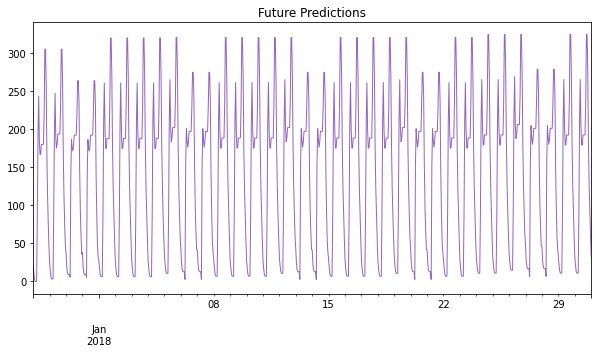

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

# Creation of Class and functions to be able to run prediction from new file

In [ ]:
class create_model():

    def run_model(self, features, target, given_df, months_to_pred):
        df = create_features(given_df)

        X_all = df[features]
        y_all = df[target]

        reg = xgb.XGBRegressor(base_score=0.5,
                               booster='gbtree',
                               n_estimators=500,
                               objective='reg:linear',
                               max_depth=3,
                               learning_rate=0.01)
        reg.fit(X_all, y_all,
                eval_set=[(X_all, y_all)],
                verbose=100)

        # Create future dataframe
        start_date = df.index.max()
        end_date = start_date + relativedelta(months=months_to_pred)
        end_date = end_date.strftime('%Y-%m-%d')
        future = pd.date_range(start_date,end_date, freq='1h')
        future_df = pd.DataFrame(index=future)
        future_df['isFuture'] = True
        df['isFuture'] = False
        df_and_future = pd.concat([df, future_df])
        df_and_future = create_features(df_and_future)

        future_w_features = df_and_future.query('isFuture').copy()
        future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

        return future_w_features

    def plot_future(self, future_df):
        future_df['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
        plt.show()



In [ ]:
def run_on_new_data(given_df, months_to_pred):
    features = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'holiday', 'weather','temp','temp_felt', 'humidity','windspeed']
    target = 'type_ab'
    model = create_model()
    future_df = model.run_model(features, target, given_df, months_to_pred)
    final_predictions = model.plot_future(future_df)
    return final_predictions


In [ ]:
#put new to import csv here
given_df = new_df

months_to_pred = 2

run_on_new_data(given_df, months_to_pred)


# Final Thoughts:
For future analysis it would be great to tune the model more and try different models such as XGBoost with Fourier Terms. Also, it would be interesting to explore the trends more and include lag features.